Text(0, 0.5, 'Voltage (kV)')

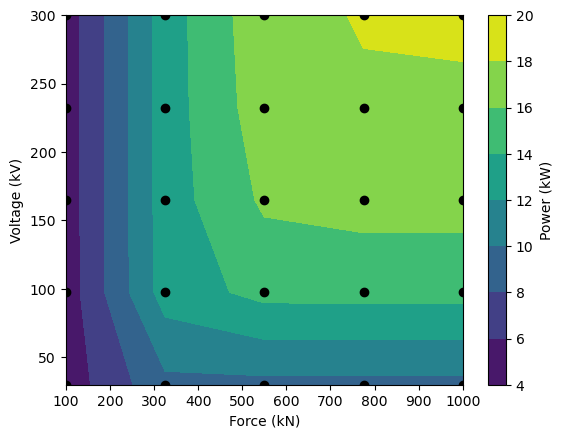

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp

# import WecOptTool results csv
df = pd.read_csv('power_sensitivities_2.csv')

# extract the points where position is unconstrained
#max_x = df['x_max'].max()
#df_x_unconstrained = df[df['x_max'] == max_x]
df_x_unconstrained = df
force = df_x_unconstrained['f_max']
voltage = df_x_unconstrained['Vs_max']
power = -df_x_unconstrained['electrical Power']

# reshape to 2D
force_u = force.unique()
voltage_u = voltage.unique()
num_forces = len(force_u)
num_voltages = len(voltage_u)
force = force.values.reshape(num_forces, num_voltages)
voltage = voltage.values.reshape(num_forces, num_voltages)
power = power.values.reshape(num_forces, num_voltages)

# contour plot of power
plt.contourf(force/1000, voltage/1000, power/1000)
plt.colorbar(label='Power (kW)')
plt.scatter(force/1000, voltage/1000, c='k')
plt.xlabel('Force (kN)')
plt.ylabel('Voltage (kV)')


In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
P_max = np.max(power)

def guess(f, v, a0, a1, a2, a3, a4, a5):
    return P_max * (a5*(f*v)**5 + a4*(f*v)**4 + a3*(f*v)**3 + a2*(f*v)**2 + a1*(f*v) + a0)

def _guess(M, *args):
    f, v = M
    return guess(f, v, *args)

# Prepare input data for curve fitting
xdata = np.vstack((force.ravel(), voltage.ravel()))
p0 = [10, 10, 10, 10, 10, 10]  # Initial guesses

# Function to update the plot based on slider values
def update_plot(a0, a1, a2, a3, a4, a5):
    try:
        opt_param, _ = curve_fit(_guess, xdata, power.ravel(), p0=[a0, a1, a2, a3, a4, a5])
        power_surrogate = guess(force, voltage, *opt_param).reshape(num_forces, num_voltages)

        plt.figure(figsize=(12, 8))

        # Plot the results
        plt.subplot(2, 2, 1)
        plt.contourf(force/1000, voltage/1000, power_surrogate/1000, vmin=4, vmax=20, levels=15)
        plt.colorbar(label='Power (kW)')
        plt.xlabel('Force (kN)')
        plt.ylabel('Voltage (kV)')
        plt.title('Surrogate Power Surface')

        plt.subplot(2, 2, 2)
        plt.plot(force_u/1000, power[:, -1]/1000, label='Voltage = max')
        plt.plot(force_u/1000, power_surrogate[:, -1]/1000, label='Surrogate')
        plt.xlabel('Force (kN)')
        plt.ylabel('Power (kW)')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(voltage_u/1000, power[-1, :]/1000, label='Force = max')
        plt.plot(voltage_u/1000, power_surrogate[-1, :]/1000, label='Surrogate')
        plt.xlabel('Voltage (kV)')
        plt.ylabel('Power (kW)')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")

# Create sliders for each parameter
a0_slider = widgets.FloatSlider(value=p0[0], min=-100, max=100, step=1, description='a0')
a1_slider = widgets.FloatSlider(value=p0[1], min=-100, max=100, step=1, description='a1')
a2_slider = widgets.FloatSlider(value=p0[2], min=-100, max=100, step=1, description='a2')
a3_slider = widgets.FloatSlider(value=p0[3], min=-100, max=100, step=1, description='a3')
a4_slider = widgets.FloatSlider(value=p0[4], min=-100, max=100, step=1, description='a4')
a5_slider = widgets.FloatSlider(value=p0[5], min=-100, max=100, step=1, description='a5')

# Link the sliders to the update_plot function
widgets.interactive(update_plot, 
                    a0=a0_slider, 
                    a1=a1_slider, 
                    a2=a2_slider, 
                    a3=a3_slider, 
                    a4=a4_slider, 
                    a5=a5_slider)

plt.show()

In [7]:

# interpolate to get normalized power
force_i = np.linspace(force_u[0], force_u[-1], 10)
voltage_i = np.linspace(voltage_u[0], voltage_u[-1], 10)
force_i, voltage_i = np.meshgrid(force_i, voltage_i)
points = (force_u, voltage_u)
values = power_surrogate
xi = (force_i, voltage_i)
power_interp = interp.interpn(points, values, xi)


In [8]:

# import joint probability distribution from file
file = 'Humboldt_California_Wave Resource _SAM CSV.csv'
jpd = pd.read_csv(file, skiprows=2, header=None).values
probabilities = jpd[1:, 1:].astype(float),  # joint probability distribution of wave (%)
Hs = jpd[1:, 0].astype(float),  # wave height (m)
Te = jpd[0, 1:].astype(float),  # wave period (s)

# En's sims assumed a wave with wavefreq = 0.3 Hz, amplitude = 1
# scale the normalized power to get power matrix for different sea states
Te_base = 1/0.3
Hs_base = 2
Te, Hs = np.meshgrid(Te, Hs)
power_multiplier = (Hs/Hs_base)**2 * (Te/Te_base)
power_matrix = np.expand_dims(power_interp, axis=(2,3)) * power_multiplier
print(power_matrix.shape) # (num forces interp, num voltages interp, num Hs num Te)
# fixme: the power multiplier should include the fact that there is a different 
# relative force limit, and therefore different power_interp, for each sea state

# plot power matrix for one force/voltage combo
plt.figure()
plt.contourf(Hs, Te, power_matrix[0,0,:,:]/1000)
plt.colorbar(label='Power (kW)')
plt.xlabel('Hs (m)')
plt.ylabel('Te (s)')

# calculate annual energy production
P_weighted = power_matrix * probabilities / 100
P_elec = np.sum(P_weighted, axis=(2,3)) # sum over sea states
hr_per_yr = 8766
aep = P_elec * hr_per_yr / 1000 # kWh

# plot annual energy production for all force/voltage combos
plt.figure()
plt.contourf(force_i/1000, voltage_i/1000, aep/1000)
plt.colorbar(label='AEP (MWh)')
plt.xlabel('Force (kN)')
plt.ylabel('Voltage (kV)')


FileNotFoundError: [Errno 2] No such file or directory: 'Humboldt_California_Wave Resource _SAM CSV.csv'

Text(0.5, 1.0, 'Saturated Torque and Voltage')

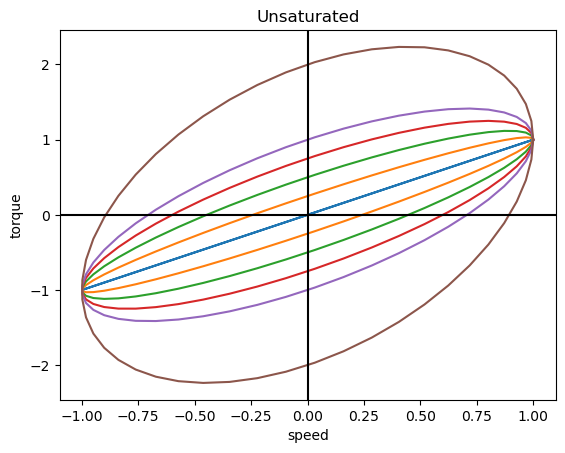

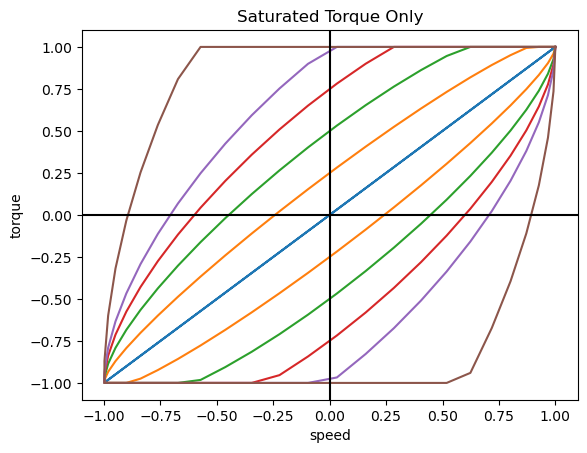

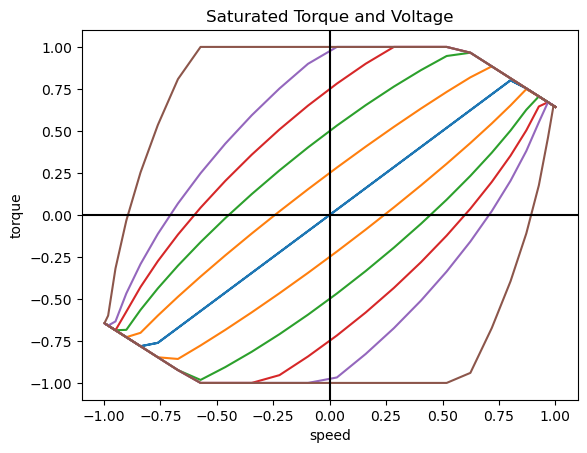

In [ ]:
# provide a nondimensional torque-speed contour
t = np.linspace(0,2*np.pi)
x = np.sin(t)
xdot = np.cos(t)
a_vals = [0,0.25,0.5,0.75,1,2]

for a in a_vals:
    plt.figure(1)
    T = xdot + a * x
    plt.plot(xdot,T, label=f'a = {a}')

    plt.figure(2)
    T_sat = np.clip(T, -1, 1)
    plt.plot(xdot,T_sat, label=f'a = {a}')

    plt.figure(3)
    base_over_max_speed = 0.4
    T_voltage_y_intercept = 1.5
    base_speed = 0.7
    T_voltage_x_intercept = base_speed / base_over_max_speed
    voltage_slope = -T_voltage_y_intercept / T_voltage_x_intercept
    T_voltage = T_voltage_y_intercept + voltage_slope * np.abs(xdot)
    T_sat_sat = np.clip(T_sat, -T_voltage, T_voltage)
    plt.plot(xdot,T_sat_sat, label=f'a = {a}')

plt.figure(1)
plt.xlabel('speed')
plt.ylabel('torque')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('Unsaturated')

plt.figure(2)
plt.xlabel('speed')
plt.ylabel('torque')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('Saturated Torque Only')

plt.figure(3)
plt.xlabel('speed')
plt.ylabel('torque')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.title('Saturated Torque and Voltage')

In [ ]:
# torque speed contour for each sea state

# scale the WecOptTool torque by Hs and scale the WecOptTool speed by 1/Te


Text(0, 0.5, 'Radiation Damping (N/(m/s))')

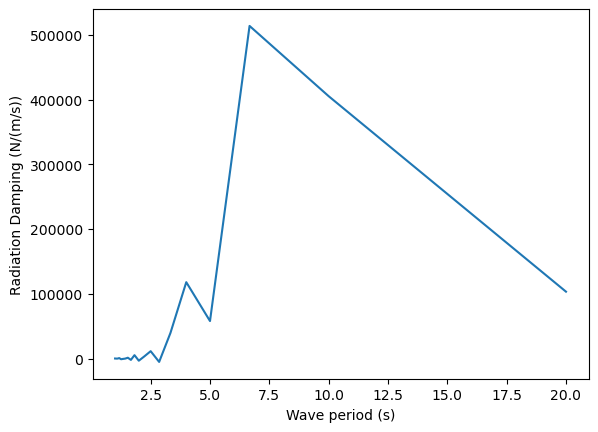

In [ ]:
# check damping vs frequency from WecOptTool results
rho = 1030
f1 = 0.05
B_df = pd.read_csv('damping_vs_omega.csv')
T = 2*np.pi/B_df['omega']
B = B_df['damping_normalized']*rho*f1*2*np.pi
plt.plot(T, B)
plt.xlabel('Wave period (s)')
plt.ylabel('Radiation Damping (N/(m/s))')

# maximum power assuming perfect impedance matching and 100% efficiency
P_max = F_e**2 / (8*B)
# haskind relationship says B * 4 rho g Vg / k = (F_e/H_s)^2
# in deep water we have Vg = g/(2 w) and k = w^2/g
# so B * 4 rho g Vg / k = B * 4 rho g^2 / (2 w) * g / w^2 = 2 B rho g^3 / w^3
# which means B = w^3 / (2 rho g^3) * (F_e / H_s)^2
# and so P_max = F_e^2 / (8 * w^3 / (2 rho g^3) * (F_e / H_s)^2) = 1/4 * rho g^3 H_s^2 / w^3

# compare against P_wave_per_m = rho g^2 Hs^2  / (32 w)
# CW_max = g/ w^2
# gives P_max = rho g^3 Hs^2 / (32 w^3)
# which is off by a factor of 8 from the above

# if B were too small by a factor of x then F_e would be too small by a factor of sqrt(x)
# and power would change by a factor of sqrt(x)^2/x = 1
# so power wouldn't change, so B being too big/small is not the issue